# Step-by-Step Percentile Optimization (Manual Multi-Item Example)

This walkthrough manually builds data for **5 unique items**, each with unique numeric characteristics, using:

- **20 days history** (backtest period)
- **14 days replenishment period** (evaluation period)
- **Percentile candidates every 5%** with multipliers around the mean forecast

The goal is to make every controllable parameter explicit so you can show how policy tuning behaves.

## 1) Imports and reproducibility
This cell sets up the notebook runtime:
- `from __future__ import annotations` enables forward references in type hints.
- Standard library imports cover dates, randomness, and small utilities.
- We add the repo `src/` to `sys.path` so the local `replenishment` package is importable.


In [1]:
from __future__ import annotations

from dataclasses import replace
from datetime import date, timedelta
import random
import matplotlib.pyplot as plt
import pandas as pd

from replenishment import (
    PercentileForecastOptimizationPolicy,
    RopPercentileForecastOptimizationPolicy,
    StandardSimulationRow,
    build_percentile_forecast_candidates_from_standard_rows,
    build_replenishment_decisions_from_simulations,
    evaluate_forecast_target_costs,
    optimize_forecast_targets,
    plot_replenishment_decisions,
    replenishment_decision_rows_to_dataframe,
    simulate_replenishment,
    simulate_replenishment_with_aggregation,
    split_standard_simulation_rows,
    standard_simulation_rows_to_dataframe,
)


## 2) Global configuration (all explicit)

In [2]:
# Date + horizon controls
START_DATE = date(2032, 1, 1)
FREQUENCY_DAYS = 1
HISTORY_DAYS = 80
REPLENISHMENT_DAYS = 14
TOTAL_DAYS = HISTORY_DAYS + REPLENISHMENT_DAYS
FORECAST_START_PERIOD = HISTORY_DAYS

# Policy cadence controls
POLICY_MODE = "base_stock"  # alternatives: "base_stock" or "rop"
REVIEW_PERIOD_DEFAULT = 3
FORECAST_HORIZON_DEFAULT = 3
RMSE_WINDOW_DEFAULT = REVIEW_PERIOD_DEFAULT
AGGREGATION_WINDOW = 3

# Candidate-generation controls
INCLUDE_MEAN_CANDIDATE = True
USE_CURRENT_STOCK_BACKTEST = False
USE_CURRENT_STOCK_FORECAST = True

# Randomness controls
SEED = 20260211
rng = random.Random(SEED)

# Percentile grid controls: every 5% from p05 to p95
PERCENTILE_STEP = 5
PERCENTILE_LEVELS = list(range(5, 100, PERCENTILE_STEP))
MULTIPLIER_AT_P05 = 0.55
MULTIPLIER_AT_P95 = 1.45

def multiplier_from_percentile(percentile: int) -> float:
    span = (MULTIPLIER_AT_P95 - MULTIPLIER_AT_P05) / (95 - 5)
    return round(MULTIPLIER_AT_P05 + (percentile - 5) * span, 3)

def percentile_label(percentile: int) -> str:
    if percentile < 50:
        return f"p{percentile:02d}_lower"
    if percentile > 50:
        return f"p{percentile:02d}_upper"
    return "p50"

PERCENTILE_MULTIPLIERS = {
    percentile_label(p): multiplier_from_percentile(p)
    for p in PERCENTILE_LEVELS
}

# Target list passed into optimizer (explicit).
CANDIDATE_TARGETS = list(PERCENTILE_MULTIPLIERS.keys())
if INCLUDE_MEAN_CANDIDATE:
    CANDIDATE_TARGETS.append("mean")

print(f"Total periods per item: {TOTAL_DAYS}")
print(f"Percentile candidates: {len(PERCENTILE_MULTIPLIERS)}")
print("Example multipliers:", dict(list(PERCENTILE_MULTIPLIERS.items())[:5]))


Total periods per item: 94
Percentile candidates: 19
Example multipliers: {'p05_lower': 0.55, 'p10_lower': 0.6, 'p15_lower': 0.65, 'p20_lower': 0.7, 'p25_lower': 0.75}


## 3) Manual item-level setup (5 unique IDs with unique numeric characteristics)

In [3]:
ITEM_CONFIG = {
    "SKU_A": {
        "holding_cost_per_unit": 0.35,
        "stockout_cost_per_unit": 11.0,
        "order_cost_per_order": 11.0,
        "order_cost_per_unit": 0.05,
        "lead_time": 1,
        "review_period": 3,
        "forecast_period": 3,
        "initial_on_hand": 32,
        "current_stock": 29,
        "history_base": 20.0,
        "history_trend": 0.10,
        "history_weekly_amp": 3.0,
        "history_noise_std": 1.8,
        "forecast_base": 21.0,
        "forecast_trend": 0.12,
        "forecast_weekly_amp": 2.2,
        "forecast_noise_std": 1.4,
        "future_actual_noise_std": 2.0,
    },
    "SKU_B": {
        "holding_cost_per_unit": 0.60,
        "stockout_cost_per_unit": 6.0,
        "order_cost_per_order": 8.0,
        "order_cost_per_unit": 0.08,
        "lead_time": 2,
        "review_period": 3,
        "forecast_period": 3,
        "initial_on_hand": 26,
        "current_stock": 21,
        "history_base": 16.0,
        "history_trend": -0.05,
        "history_weekly_amp": 4.0,
        "history_noise_std": 2.2,
        "forecast_base": 15.5,
        "forecast_trend": -0.03,
        "forecast_weekly_amp": 3.5,
        "forecast_noise_std": 1.6,
        "future_actual_noise_std": 2.6,
    },
    "SKU_C": {
        "holding_cost_per_unit": 0.95,
        "stockout_cost_per_unit": 3.0,
        "order_cost_per_order": 14.0,
        "order_cost_per_unit": 0.10,
        "lead_time": 3,
        "review_period": 3,
        "forecast_period": 3,
        "initial_on_hand": 38,
        "current_stock": 31,
        "history_base": 24.0,
        "history_trend": 0.08,
        "history_weekly_amp": 5.0,
        "history_noise_std": 2.8,
        "forecast_base": 25.0,
        "forecast_trend": 0.10,
        "forecast_weekly_amp": 4.0,
        "forecast_noise_std": 2.1,
        "future_actual_noise_std": 3.0,
    },
    "SKU_D": {
        "holding_cost_per_unit": 0.45,
        "stockout_cost_per_unit": 1.0,
        "order_cost_per_order": 17.0,
        "order_cost_per_unit": 0.12,
        "lead_time": 4,
        "review_period": 3,
        "forecast_period": 3,
        "initial_on_hand": 42,
        "current_stock": 34,
        "history_base": 28.0,
        "history_trend": -0.02,
        "history_weekly_amp": 6.0,
        "history_noise_std": 3.1,
        "forecast_base": 27.0,
        "forecast_trend": -0.01,
        "forecast_weekly_amp": 5.3,
        "forecast_noise_std": 2.5,
        "future_actual_noise_std": 3.4,
    },
    "SKU_E": {
        "holding_cost_per_unit": 1.20,
        "stockout_cost_per_unit": 21.0,
        "order_cost_per_order": 20.0,
        "order_cost_per_unit": 0.16,
        "lead_time": 5,
        "review_period": 3,
        "forecast_period": 3,
        "initial_on_hand": 50,
        "current_stock": 39,
        "history_base": 34.0,
        "history_trend": 0.05,
        "history_weekly_amp": 7.0,
        "history_noise_std": 3.8,
        "forecast_base": 35.0,
        "forecast_trend": 0.08,
        "forecast_weekly_amp": 6.5,
        "forecast_noise_std": 2.9,
        "future_actual_noise_std": 4.2,
    },
}

ITEM_CONFIG_DF = pd.DataFrame.from_dict(ITEM_CONFIG, orient="index")
ITEM_CONFIG_DF


,holding_cost_per_unit,stockout_cost_per_unit,order_cost_per_order,order_cost_per_unit,lead_time,review_period,forecast_period,initial_on_hand,current_stock,history_base,history_trend,history_weekly_amp,history_noise_std,forecast_base,forecast_trend,forecast_weekly_amp,forecast_noise_std,future_actual_noise_std
SKU_A,0.35,11.0,11.0,0.05,1,3,3,32,29,20.0,0.10,3.0,1.8,21.0,0.12,2.2,1.4,2.0
SKU_B,0.60,6.0,8.0,0.08,2,3,3,26,21,16.0,-0.05,4.0,2.2,15.5,-0.03,3.5,1.6,2.6
SKU_C,0.95,3.0,14.0,0.10,3,3,3,38,31,24.0,0.08,5.0,2.8,25.0,0.10,4.0,2.1,3.0
SKU_D,0.45,1.0,17.0,0.12,4,3,3,42,34,28.0,-0.02,6.0,3.1,27.0,-0.01,5.3,2.5,3.4
SKU_E,1.20,21.0,20.0,0.16,5,3,3,50,39,34.0,0.05,7.0,3.8,35.0,0.08,6.5,2.9,4.2


## 4) Build rows manually
We create a small synthetic dataset by sampling history and forecast values for each SKU.
Each row is a `StandardSimulationRow`, which the replenishment helpers expect.


In [4]:
def _sample_int(mean: float, std: float) -> int:
    return max(0, int(round(rng.gauss(mean, std))))

rows: list[StandardSimulationRow] = []
for unique_id, cfg in ITEM_CONFIG.items():
    for period in range(TOTAL_DAYS):
        ds = (START_DATE + timedelta(days=period * FREQUENCY_DAYS)).isoformat()
        is_forecast = period >= FORECAST_START_PERIOD

        history_mean = cfg["history_base"] + cfg["history_trend"] * period
        forecast_mean = cfg["forecast_base"] + cfg["forecast_trend"] * period

        mean_forecast = _sample_int(forecast_mean, cfg["forecast_noise_std"])
        if is_forecast:
            actuals = _sample_int(forecast_mean, cfg["future_actual_noise_std"])
        else:
            actuals = _sample_int(history_mean, cfg["history_noise_std"])

        forecast_percentiles = {
            label: max(0, int(round(mean_forecast * multiplier)))
            for label, multiplier in PERCENTILE_MULTIPLIERS.items()
        }

        rows.append(
            StandardSimulationRow(
                unique_id=unique_id,
                ds=ds,
                demand=actuals,
                forecast=mean_forecast,
                actuals=actuals,
                holding_cost_per_unit=cfg["holding_cost_per_unit"],
                stockout_cost_per_unit=cfg["stockout_cost_per_unit"],
                order_cost_per_order=cfg["order_cost_per_order"],
                lead_time=cfg["lead_time"],
                initial_on_hand=cfg["initial_on_hand"],
                current_stock=cfg["current_stock"],
                forecast_percentiles=forecast_percentiles,
                is_forecast=is_forecast,
            )
        )

rows_df = standard_simulation_rows_to_dataframe(rows, library="pandas", include_demand=True)
rows_df.head()


,unique_id,ds,demand,forecast,actuals,holding_cost_per_unit,stockout_cost_per_unit,order_cost_per_order,lead_time,initial_on_hand,...,forecast_p50,forecast_p55_upper,forecast_p60_upper,forecast_p65_upper,forecast_p70_upper,forecast_p75_upper,forecast_p80_upper,forecast_p85_upper,forecast_p90_upper,forecast_p95_upper
0,SKU_A,2032-01-01,21,22,21,0.35,11.0,11.0,1,32,...,22,23,24,25,26,28,29,30,31,32
1,SKU_A,2032-01-02,17,22,17,0.35,11.0,11.0,1,32,...,22,23,24,25,26,28,29,30,31,32
2,SKU_A,2032-01-03,19,22,19,0.35,11.0,11.0,1,32,...,22,23,24,25,26,28,29,30,31,32
3,SKU_A,2032-01-04,17,22,17,0.35,11.0,11.0,1,32,...,22,23,24,25,26,28,29,30,31,32
4,SKU_A,2032-01-05,19,20,19,0.35,11.0,11.0,1,32,...,20,21,22,23,24,25,26,27,28,29


In [5]:
# Quick shape checks.
assert rows_df["unique_id"].nunique() == 5
assert rows_df.shape[0] == 5 * TOTAL_DAYS
assert rows_df.loc[rows_df["is_forecast"] == False].shape[0] == 5 * HISTORY_DAYS
assert rows_df.loc[rows_df["is_forecast"] == True].shape[0] == 5 * REPLENISHMENT_DAYS
rows_df.groupby(["unique_id", "is_forecast"]).size().unstack()

is_forecast,False,True
unique_id,,
SKU_A,80,14
SKU_B,80,14
SKU_C,80,14
SKU_D,80,14
SKU_E,80,14


## 5) Plot original series

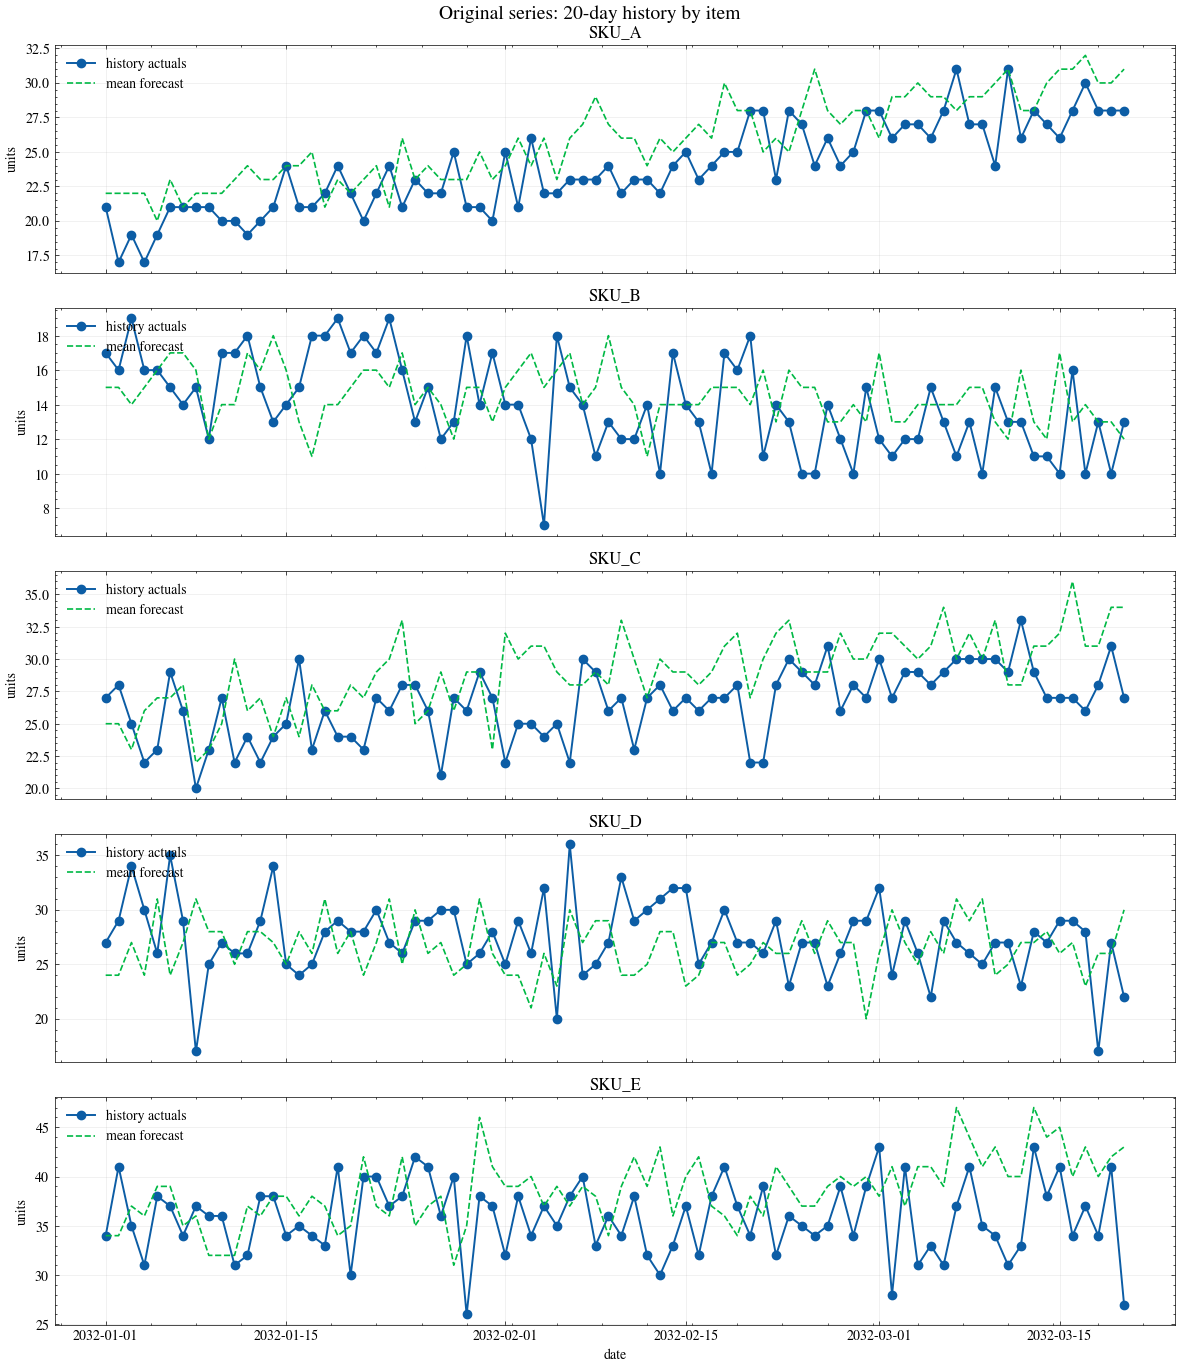

In [6]:
history_df = rows_df.loc[rows_df["is_forecast"] == False].copy()
history_df["ds"] = pd.to_datetime(history_df["ds"])

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 14), sharex=True)
for ax, unique_id in zip(axes, sorted(history_df["unique_id"].unique()), strict=False):
    d = history_df.loc[history_df["unique_id"] == unique_id].sort_values("ds")
    ax.plot(d["ds"], d["actuals"], marker="o", linewidth=1.4, label="history actuals")
    ax.plot(d["ds"], d["forecast"], linestyle="--", linewidth=1.2, label="mean forecast")
    ax.set_title(unique_id)
    ax.set_ylabel("units")
    ax.grid(alpha=0.25)
    ax.legend(loc="upper left")

axes[-1].set_xlabel("date")
fig.suptitle("Original series: 20-day history by item", fontsize=14)
fig.tight_layout()
plt.show()

## 6) Split backtest (history) vs replenishment horizon

In [7]:
backtest_rows, forecast_rows = split_standard_simulation_rows(rows)
print(f"Backtest rows: {len(backtest_rows)}")
print(f"Forecast rows: {len(forecast_rows)}")

Backtest rows: 400
Forecast rows: 70


## 7) Build candidate configs with explicit per-item controls
We translate raw rows into per-item configuration objects. These configs hold the
candidate percentile forecasts plus item-level settings (lead time, costs, cadence).


In [8]:
REVIEW_PERIOD_BY_ID = {uid: cfg.get("review_period", REVIEW_PERIOD_DEFAULT) for uid, cfg in ITEM_CONFIG.items()}
FORECAST_HORIZON_BY_ID = {uid: FORECAST_HORIZON_DEFAULT for uid in ITEM_CONFIG}
RMSE_WINDOW_BY_ID = {uid: RMSE_WINDOW_DEFAULT for uid in ITEM_CONFIG}
ORDER_COST_PER_UNIT_BY_ID = {uid: cfg["order_cost_per_unit"] for uid, cfg in ITEM_CONFIG.items()}

backtest_configs = build_percentile_forecast_candidates_from_standard_rows(
    backtest_rows,
    include_mean=INCLUDE_MEAN_CANDIDATE,
    use_current_stock=USE_CURRENT_STOCK_BACKTEST,
    review_period=REVIEW_PERIOD_BY_ID,
    forecast_horizon=FORECAST_HORIZON_BY_ID,
)
backtest_configs = {
    uid: replace(cfg, order_cost_per_unit=ORDER_COST_PER_UNIT_BY_ID[uid])
    for uid, cfg in backtest_configs.items()
}

forecast_configs = build_percentile_forecast_candidates_from_standard_rows(
    forecast_rows,
    include_mean=INCLUDE_MEAN_CANDIDATE,
    use_current_stock=USE_CURRENT_STOCK_FORECAST,
    review_period=REVIEW_PERIOD_BY_ID,
    forecast_horizon=FORECAST_HORIZON_BY_ID,
)
forecast_configs = {
    uid: replace(cfg, order_cost_per_unit=ORDER_COST_PER_UNIT_BY_ID[uid])
    for uid, cfg in forecast_configs.items()
}

len(backtest_configs), len(forecast_configs)


(5, 5)

## 8) Evaluate full target grid and optimize percentile target
We simulate every candidate percentile on the backtest portion and record its cost.
Then we pick the target with the lowest total cost per item.


In [9]:
target_costs = evaluate_forecast_target_costs(
    backtest_configs,
    candidate_targets=CANDIDATE_TARGETS,
    policy_mode=POLICY_MODE,
)

cost_rows = [
    {"unique_id": uid, "target": target, "total_cost": cost}
    for uid, target_map in target_costs.items()
    for target, cost in target_map.items()
]
cost_df = pd.DataFrame(cost_rows)
cost_df.head()

,unique_id,target,total_cost
0,SKU_A,p05_lower,8855.35
1,SKU_A,p10_lower,7720.65
2,SKU_A,p15_lower,6643.25
3,SKU_A,p20_lower,5660.95
4,SKU_A,p25_lower,4667.90


### Debug: cost breakdown by target (backtest)
This table shows how total cost is composed (holding, stockout, ordering) for each target.


In [10]:
debug_rows = []
for unique_id, config in backtest_configs.items():
    for target in CANDIDATE_TARGETS:
        series = config.forecast_candidates[target]
        if POLICY_MODE == "base_stock":
            policy = PercentileForecastOptimizationPolicy(
                forecast=series,
                lead_time=config.lead_time,
                review_period=config.review_period,
                forecast_horizon=config.forecast_horizon,
            )
        elif POLICY_MODE == "rop":
            policy = RopPercentileForecastOptimizationPolicy(
                forecast=series,
                lead_time=config.lead_time,
                review_period=config.review_period,
                forecast_horizon=config.forecast_horizon,
            )
        else:
            raise ValueError("POLICY_MODE must be 'base_stock' or 'rop'.")

        simulation = simulate_replenishment(
            periods=config.periods,
            demand=config.demand,
            initial_on_hand=config.initial_on_hand,
            lead_time=config.lead_time,
            policy=policy,
                holding_cost_per_unit=config.holding_cost_per_unit,
            stockout_cost_per_unit=config.stockout_cost_per_unit,
            order_cost_per_order=config.order_cost_per_order,
            order_cost_per_unit=config.order_cost_per_unit,
        )
        summary = simulation.summary
        debug_rows.append(
            {
                "unique_id": unique_id,
                "target": target,
                "holding_cost": round(summary.holding_cost, 2),
                "stockout_cost": round(summary.stockout_cost, 2),
                "ordering_cost": round(summary.ordering_cost, 2),
                "total_cost": round(summary.total_cost, 2),
                "lost_sales_units": summary.total_demand - summary.total_fulfilled,
                "fill_rate": round(summary.fill_rate, 4),
            }
        )

debug_df = (
    pd.DataFrame(debug_rows)
    .sort_values(["unique_id", "total_cost"])
    .reset_index(drop=True)
)
debug_df.head(20)


,unique_id,target,holding_cost,stockout_cost,ordering_cost,total_cost,lost_sales_units,fill_rate
0,SKU_A,p50,848.40,0.0,394.10,1242.50,0,1.0000
1,SKU_A,mean,848.40,0.0,394.10,1242.50,0,1.0000
2,SKU_A,p45_lower,758.45,176.0,393.00,1327.45,16,0.9916
3,SKU_A,p55_upper,943.95,0.0,394.40,1338.35,0,1.0000
4,SKU_A,p60_upper,1064.70,0.0,394.55,1459.25,0,1.0000
5,SKU_A,p65_upper,1162.35,0.0,394.85,1557.20,0,1.0000
6,SKU_A,p70_upper,1281.00,0.0,395.00,1676.00,0,1.0000
7,SKU_A,p75_upper,1388.10,0.0,395.30,1783.40,0,1.0000
8,SKU_A,p40_lower,658.00,814.0,389.95,1861.95,74,0.9612
9,SKU_A,p80_upper,1491.00,0.0,395.45,1886.45,0,1.0000


### Debug plot: holding vs stockout cost by percentile
These plots show how holding and stockout costs change as the target percentile moves.


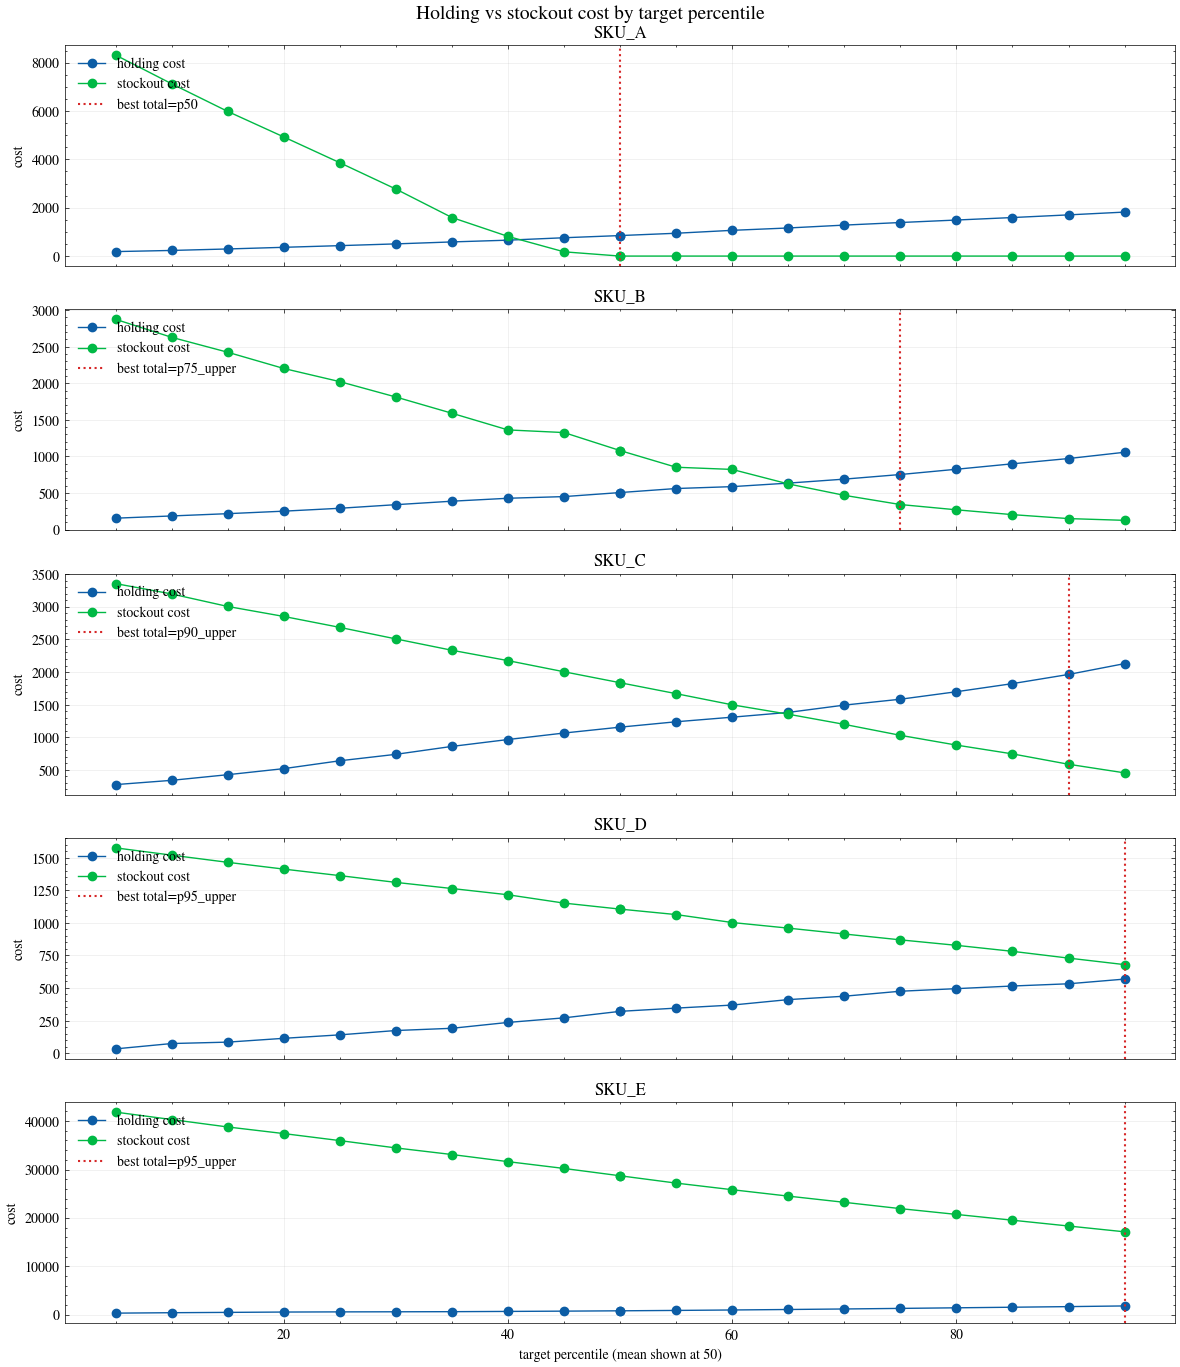

In [11]:
def _target_order_key(value: object) -> float:
    if isinstance(value, str) and value.lower() == "mean":
        return 50.0
    text = str(value)
    if text.startswith("p"):
        digits = "".join(ch for ch in text[1:] if ch.isdigit())
        if digits:
            return float(digits)
    return float(text)

plot_costs_df = debug_df.copy()
plot_costs_df["target_order"] = plot_costs_df["target"].map(_target_order_key)

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 14), sharex=True)
for ax, unique_id in zip(axes, sorted(plot_costs_df["unique_id"].unique()), strict=False):
    d = plot_costs_df.loc[plot_costs_df["unique_id"] == unique_id].sort_values("target_order")
    ax.plot(d["target_order"], d["holding_cost"], marker="o", label="holding cost")
    ax.plot(d["target_order"], d["stockout_cost"], marker="o", label="stockout cost")
    best_row = d.loc[d["total_cost"].idxmin()]
    ax.axvline(
        best_row["target_order"],
        color="tab:red",
        linestyle=":",
        linewidth=1.5,
        label=f"best total={best_row['target']}"
    )

    ax.set_title(unique_id)
    ax.set_ylabel("cost")
    ax.grid(alpha=0.25)
    ax.legend(loc="upper left")

axes[-1].set_xlabel("target percentile (mean shown at 50)")
fig.suptitle("Holding vs stockout cost by target percentile", fontsize=14)
fig.tight_layout()
plt.show()


In [12]:
optimized = optimize_forecast_targets(
    backtest_configs,
    candidate_targets=CANDIDATE_TARGETS,
    policy_mode=POLICY_MODE,
)

best_target_df = pd.DataFrame(
    [
        {
            "unique_id": uid,
            "best_target": result.target,
            "backtest_total_cost": result.simulation.summary.total_cost,
        }
        for uid, result in optimized.items()
    ]
).sort_values("unique_id")
best_target_df

,unique_id,best_target,backtest_total_cost
0,SKU_A,p50,1242.50
1,SKU_B,p75_upper,1395.68
2,SKU_C,p90_upper,3126.40
3,SKU_D,p95_upper,1895.50
4,SKU_E,p95_upper,19830.80


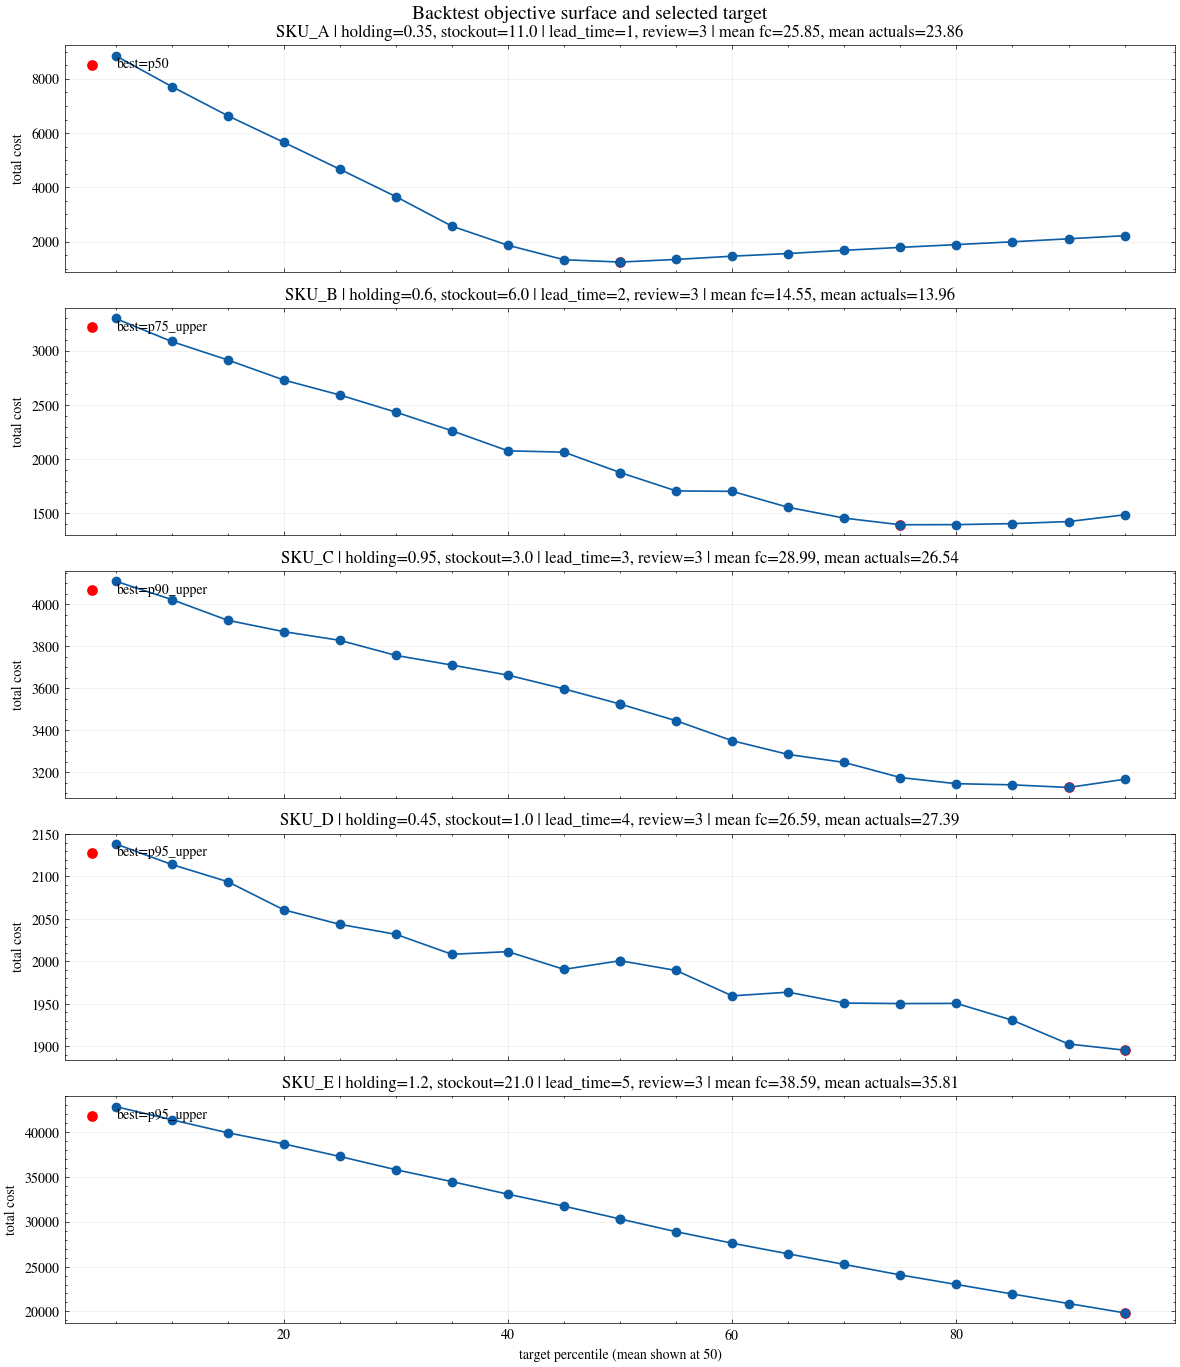

In [13]:
def _target_order_key(value: object) -> float:
    if isinstance(value, str) and value.lower() == "mean":
        return 50.0
    text = str(value)
    if text.startswith("p"):
        digits = "".join(ch for ch in text[1:] if ch.isdigit())
        if digits:
            return float(digits)
    return float(text)

plot_df = cost_df.copy()
plot_df["target_order"] = plot_df["target"].map(_target_order_key)
best_map = {uid: result.target for uid, result in optimized.items()}

backtest_stats = (
    rows_df.loc[rows_df["is_forecast"] == False]
    .groupby("unique_id")[["forecast", "actuals"]]
    .mean()
    .round(2)
)


fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 14), sharex=True)
for ax, unique_id in zip(axes, sorted(plot_df["unique_id"].unique()), strict=False):
    d = plot_df.loc[plot_df["unique_id"] == unique_id].sort_values("target_order")
    ax.plot(d["target_order"], d["total_cost"], marker="o", linewidth=1.2)
    best_target = best_map[unique_id]
    best_row = d.loc[d["target"] == best_target].iloc[0]
    ax.scatter(
        [best_row["target_order"]],
        [best_row["total_cost"]],
        color="red",
        s=45,
        label=f"best={best_target}",
    )
    cfg = ITEM_CONFIG[unique_id]
    stats = backtest_stats.loc[unique_id]
    ax.set_title(
        f"{unique_id} | holding={cfg['holding_cost_per_unit']}, stockout={cfg['stockout_cost_per_unit']} | lead_time={cfg['lead_time']}, review={cfg.get('review_period', REVIEW_PERIOD_DEFAULT)} | mean fc={stats['forecast']}, mean actuals={stats['actuals']}"
    )
    ax.set_ylabel("total cost")
    ax.grid(alpha=0.25)
    ax.legend(loc="upper left")

axes[-1].set_xlabel("target percentile (mean shown at 50)")
fig.suptitle("Backtest objective surface and selected target", fontsize=14)
fig.tight_layout()
plt.show()


## 9) Simulate replenishment period with optimized target per item
Now we apply the best percentile per SKU to the forecast period and run a
forward simulation to see the replenishment decisions and outcomes.


In [14]:
forecast_simulations = {}
for unique_id, config in forecast_configs.items():
    chosen_target = optimized[unique_id].target
    chosen_series = config.forecast_candidates[chosen_target]

    if POLICY_MODE == "base_stock":
        policy = PercentileForecastOptimizationPolicy(
            forecast=chosen_series,
            lead_time=config.lead_time,
            review_period=config.review_period,
            forecast_horizon=config.forecast_horizon,
        )
    elif POLICY_MODE == "rop":
        policy = RopPercentileForecastOptimizationPolicy(
            forecast=chosen_series,
            lead_time=config.lead_time,
            review_period=config.review_period,
            forecast_horizon=config.forecast_horizon,
        )
    else:
        raise ValueError("POLICY_MODE must be 'base_stock' or 'rop'.")

    forecast_simulations[unique_id] = simulate_replenishment_with_aggregation(
        periods=config.periods,
        demand=config.demand,
        initial_on_hand=config.initial_on_hand,
        lead_time=config.lead_time,
        policy=policy,
        aggregation_window=AGGREGATION_WINDOW,
        holding_cost_per_unit=config.holding_cost_per_unit,
        stockout_cost_per_unit=config.stockout_cost_per_unit,
        order_cost_per_order=config.order_cost_per_order,
        order_cost_per_unit=config.order_cost_per_unit,
    )

decision_rows = build_replenishment_decisions_from_simulations(
    forecast_rows,
    forecast_simulations,
    percentile_target={uid: optimized[uid].target for uid in forecast_simulations},
    review_period=REVIEW_PERIOD_BY_ID,
    forecast_horizon=FORECAST_HORIZON_BY_ID,
    rmse_window=RMSE_WINDOW_BY_ID,
)
decision_df = replenishment_decision_rows_to_dataframe(decision_rows, library="pandas")
decision_df.head()

,unique_id,ds,quantity,demand,forecast_quantity,forecast_quantity_lead_time,reorder_point,order_up_to,incoming_stock,starting_stock,...,current_stock,on_order,backorders,missed_sales,sigma,aggregation_window,review_period,forecast_horizon,rmse_window,percentile_target
0,SKU_A,2032-03-21,88,27,29.666667,30.000000,29.0,118.0,0,29,...,2,88,0,0,None,3,3,3,3,p50
1,SKU_A,2032-03-22,0,34,30.000000,30.333333,30.0,120.0,88,90,...,56,0,0,0,None,3,3,3,3,p50
2,SKU_A,2032-03-23,0,35,30.333333,31.000000,30.0,121.0,0,56,...,21,0,0,0,None,3,3,3,3,p50
3,SKU_A,2032-03-24,96,30,31.000000,32.000000,30.0,123.0,0,21,...,0,96,0,9,None,3,3,3,3,p50
4,SKU_A,2032-03-25,0,34,32.000000,32.333333,31.0,127.0,96,96,...,62,0,0,0,None,3,3,3,3,p50


In [15]:
summary_df = pd.DataFrame(
    [
        {
            "unique_id": uid,
            "best_target": optimized[uid].target,
            "eval_total_cost": sim.summary.total_cost,
            "eval_holding_cost": sim.summary.holding_cost,
            "eval_stockout_cost": sim.summary.stockout_cost,
            "eval_ordering_cost": sim.summary.ordering_cost,
            #"ending_on_hand": sim.summary.ending_on_hand,
            "total_backorders": sim.summary.total_backorders,
        }
        for uid, sim in forecast_simulations.items()
    ]
).sort_values("unique_id")
summary_df

,unique_id,best_target,eval_total_cost,eval_holding_cost,eval_stockout_cost,eval_ordering_cost,total_backorders
0,SKU_A,p50,325.90,149.10,99.0,77.80,9
1,SKU_B,p75_upper,264.00,120.00,90.0,54.00,15
2,SKU_C,p90_upper,860.35,403.75,342.0,114.60,114
3,SKU_D,p95_upper,364.89,119.25,125.0,120.64,125
4,SKU_E,p95_upper,6358.48,411.60,5796.0,150.88,276


## 10) Plot replenishment decisions for one SKU
We visualize the replenishment decisions and resulting inventory trajectory for a single item.


In [16]:
decision_df.head(10).T

,0,1,2,3,4,5,6,7,8,9
unique_id,SKU_A,SKU_A,SKU_A,SKU_A,SKU_A,SKU_A,SKU_A,SKU_A,SKU_A,SKU_A
ds,2032-03-21,2032-03-22,2032-03-23,2032-03-24,2032-03-25,2032-03-26,2032-03-27,2032-03-28,2032-03-29,2032-03-30
quantity,88,0,0,96,0,0,95,0,0,93
demand,27,34,35,30,34,31,31,29,33,32
forecast_quantity,29.666667,30.0,30.333333,31.0,32.0,32.333333,32.0,31.666667,31.0,31.666667
forecast_quantity_lead_time,30.0,30.333333,31.0,32.0,32.333333,32.0,31.666667,31.0,31.666667,31.333333
reorder_point,29.0,30.0,30.0,30.0,31.0,32.0,33.0,32.0,31.0,32.0
order_up_to,118.0,120.0,121.0,123.0,127.0,129.0,129.0,127.0,124.0,127.0
incoming_stock,0,88,0,0,96,0,0,95,0,0
starting_stock,29,90,56,21,96,62,31,95,66,33


<Axes: title={'center': 'Replenishment for SKU_A'}, xlabel='Date', ylabel='Units'>

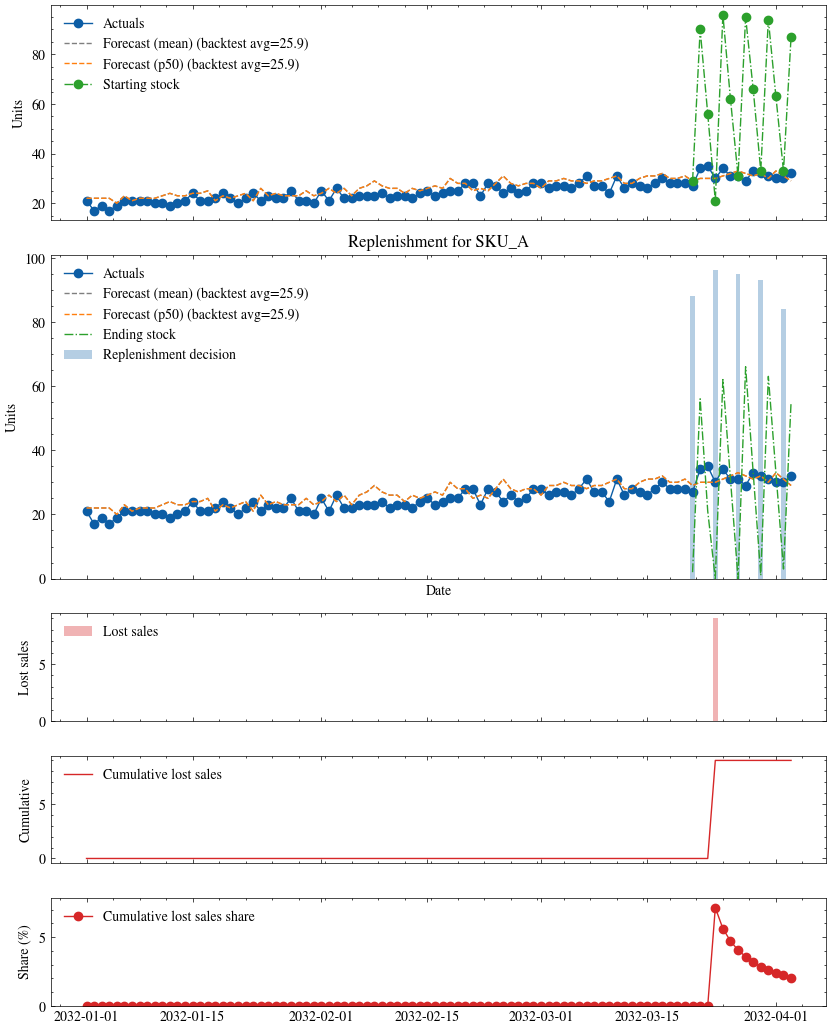

In [17]:
example_id = decision_df["unique_id"].iloc[0]
plot_replenishment_decisions(rows_df, decision_df, unique_id=example_id)


<Axes: title={'center': 'Replenishment for SKU_B'}, xlabel='Date', ylabel='Units'>

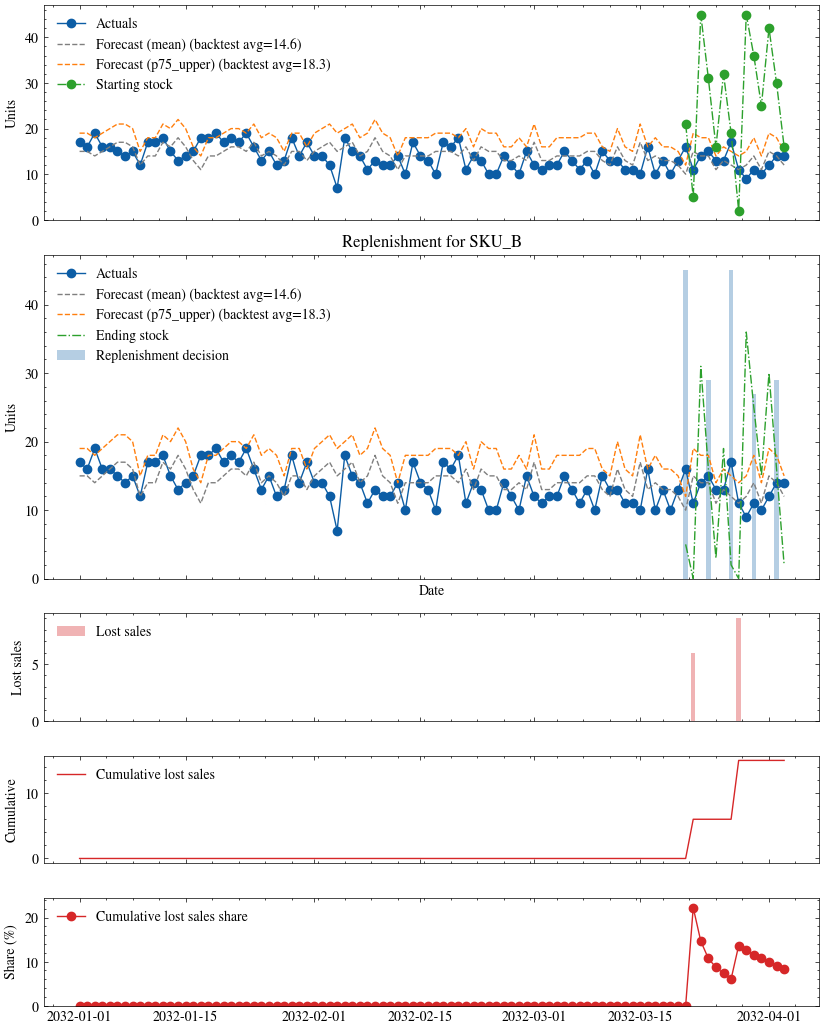

In [18]:
example_id = decision_df["unique_id"].unique().tolist()[1]
plot_replenishment_decisions(rows_df, decision_df, unique_id=example_id)

<Axes: title={'center': 'Replenishment for SKU_C'}, xlabel='Date', ylabel='Units'>

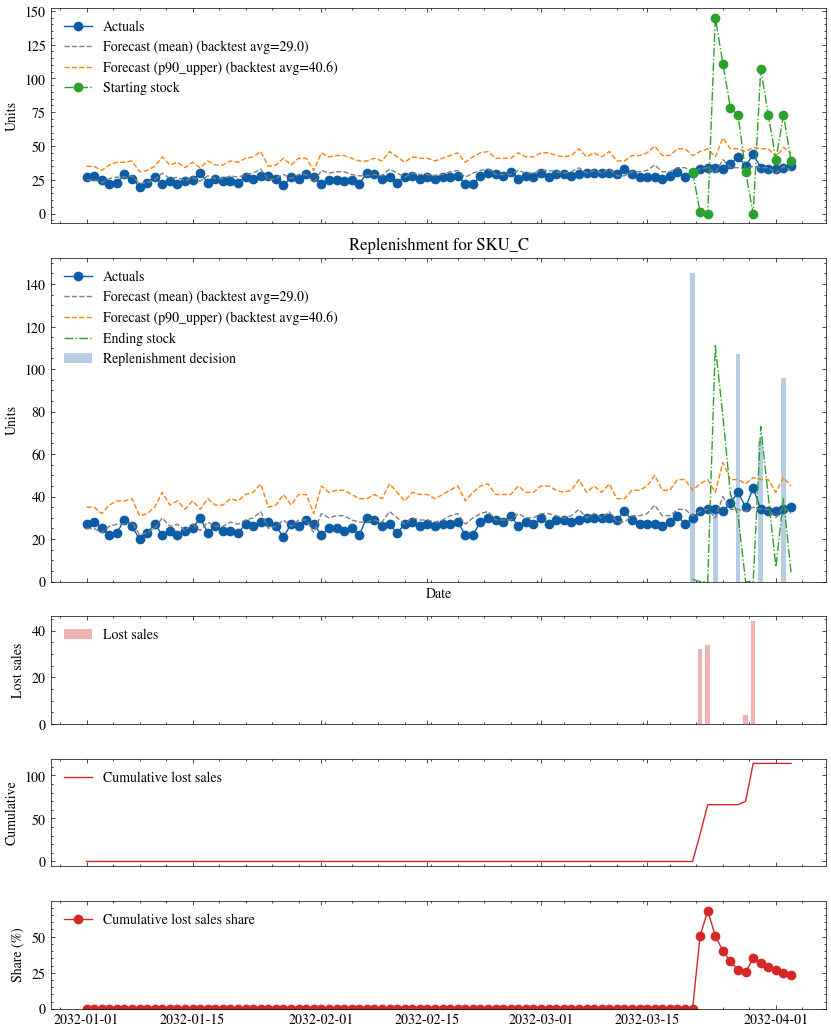

In [19]:
example_id = decision_df["unique_id"].unique().tolist()[2]
plot_replenishment_decisions(rows_df, decision_df, unique_id=example_id)

<Axes: title={'center': 'Replenishment for SKU_E'}, xlabel='Date', ylabel='Units'>

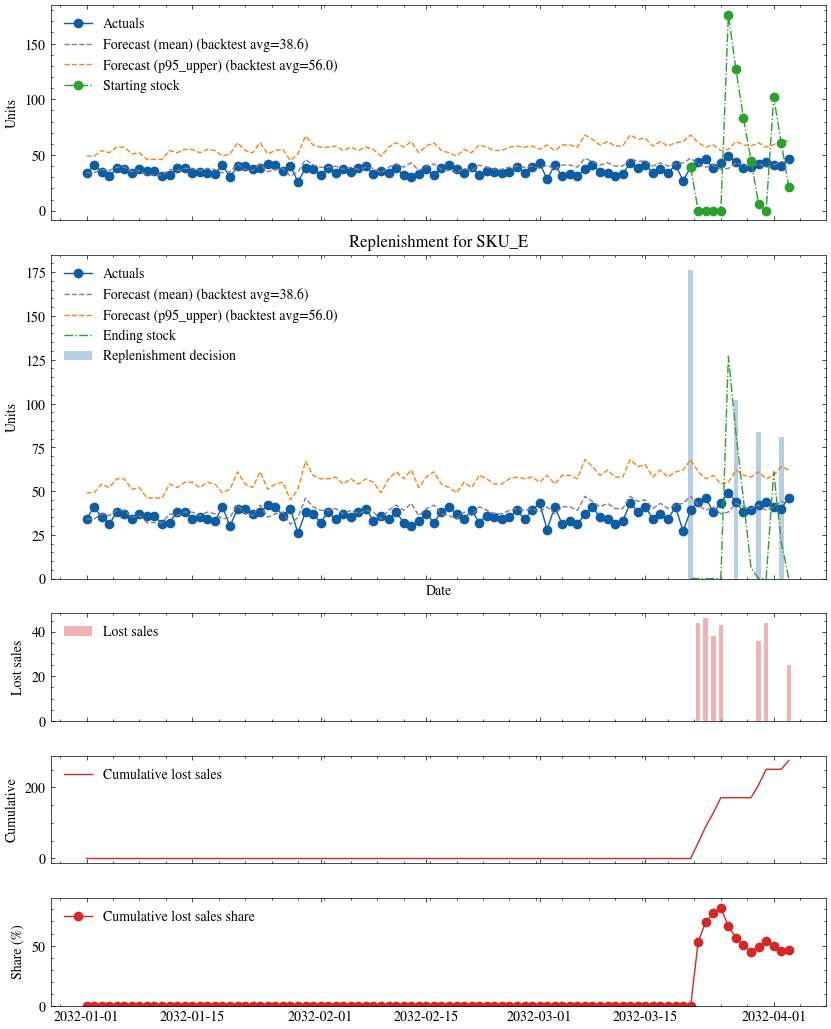

In [20]:
example_id = decision_df["unique_id"].unique().tolist()[4]
plot_replenishment_decisions(rows_df, decision_df, unique_id=example_id)